# Saliency using FullGrad Backpropagation

Implement the following saliency algorithm described in the article "Full-Gradient Representation forNeural Network Visualization", which is summarized in the following equation:

$$
f(x) = ψ(∇_xf(x)\odot x) +∑_{l\in L}∑_{c\in c_l} ψ(f^b(x)_c)
$$

This approach main idea is to add to add the individual contributions of each bias factor in the network onto the extracted gradient.

References:

- Srinivas S, Fleuret F. Full-gradient representation for neural network visualization. [arXiv preprint arXiv:1905.00780](https://arxiv.org/pdf/1905.00780.pdf), 2019.

In [1]:
import tensorflow as tf

REPETITIONS = tf.constant(20)
NOISE = tf.constant(.2)

## Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

! cp -r '/content/drive/MyDrive/Colab Notebooks/cs-no/6.grads/config' .

Mounted at /content/drive


In [3]:
from config import config, data, model, utils

from config.utils import to_image, normalize, standardize

utils.setup_clean_image_plotting()

In [4]:
from tensorflow.python.keras.applications import efficientnet

config.model.architecture = tf.keras.applications.EfficientNetB3
config.model.module = efficientnet
config.model.decode = tf.keras.applications.efficientnet.decode_predictions
config.model.preprocess = tf.keras.applications.efficientnet.preprocess_input
config.model.decompress = lambda x: x

config.data.image_size = (300, 300)
config.data.input_shape = (config.data.batch_size, 300, 300, 3)

In [5]:
images = data.load_images()
x = model.preprocess(images)

In [6]:
nn = model.build()

logits = nn(x, training=False)
preds = tf.argmax(logits, axis=1)
probs = tf.nn.softmax(logits)
decoded = model.decode(probs.numpy(), top=2)

40960/35363 [==================================] - 0s 0us/step


## FullGrad Backpropagation

In [7]:
def activation_gain(y, units):
    return tf.gather(y, units, axis=1, batch_dims=1)

def extract_bias(layer):
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        # Batch norm := ((x - m)/s)*w + b
        # Hence bias factor is -m*w/s + b.
        return (
            -layer.moving_mean * layer.gamma
            / tf.sqrt(layer.moving_variance + 1e-07)  # might be variance here.
            + layer.beta)

    if hasattr(layer, 'bias') and layer.bias is not None:
        return layer.bias

def psi(x):
    x = tf.abs(x)
    x = standardize(x)

    return x

In [8]:
layers = [(l, extract_bias(l)) for ix, l in enumerate(nn.layers[1:-1])]
layers = [(l, b) for l, b in layers if b is not None]

intermediates = [l.output for l, _ in layers]
biases = [b for _, b in layers]

print(len(biases), 'layers with bias were found.')

nn_s = tf.keras.Model(nn.inputs, [nn.output, *intermediates], name='spacial_model')

130 layers with bias were found.


In [9]:
@tf.function
def gradients(inputs, units):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        y, *ia = nn_s(inputs, training=False)
        loss = activation_gain(y, units)
    
    grads, *ig = tape.gradient(loss, [inputs, *ia])

    return loss, grads, ig

In [10]:
@tf.function
def fullgrads(inputs, units):
    loss, dydx, dydas = gradients(inputs, units)

    maps = tf.reduce_sum(psi(dydx * inputs), axis=-1)

    Gb = [ig * tf.reshape(b, (1, 1, 1, -1)) for ig, b in zip(dydas, biases)]
    for b in Gb:
        b = psi(b)
        maps += tf.reduce_sum(tf.image.resize(b, config.data.image_size), axis=-1)
    
    return loss, dydx, maps

In [11]:
r = zip(*[fullgrads(x[ix:ix+1], preds[ix:ix+1]) for ix in range(len(images))])
_, g, maps = (tf.concat(e, axis=0) for e in r)

In [12]:
maps = normalize(maps)

s = normalize(tf.reduce_sum(tf.abs(g), axis=-1))

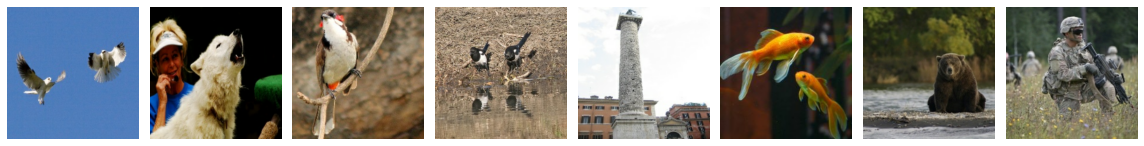

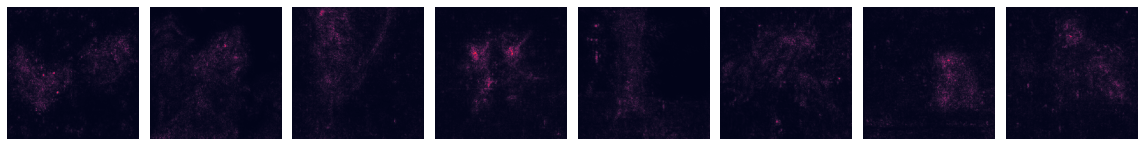

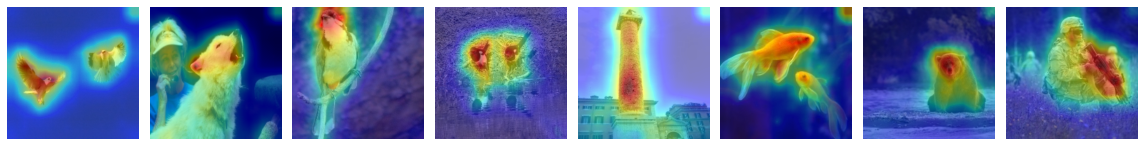

In [13]:
#@title

utils.plot(to_image(images[:8]))
utils.plot(s[:8])
utils.plot_heatmaps(to_image(images[:8]), maps)

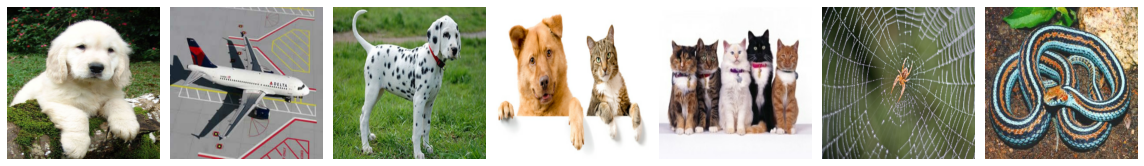

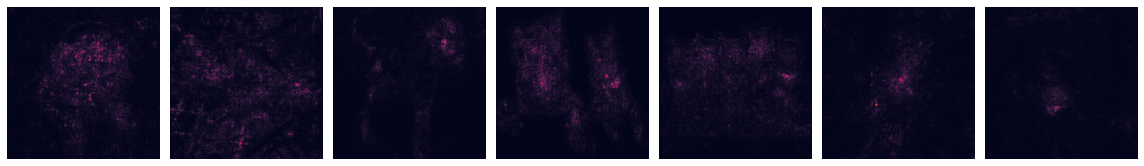

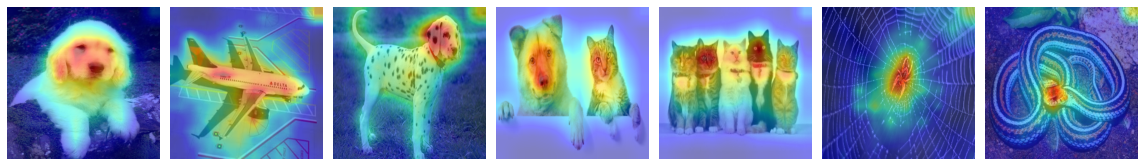

In [14]:
#@title

utils.plot(to_image(images[8:]))
utils.plot(s[8:])
utils.plot_heatmaps(to_image(images[8:]), maps[8:])

## Smooth FullGrad Backpropagation

In [17]:
def reduce_noise(x, num_samples):
    x = tf.reshape(x, (-1, num_samples, *x.shape[1:]))
    x = tf.reduce_mean(x, axis=1)
    return x

@tf.function
def smooth_gradients(inputs, units, num_samples=50, noise=.2):
    x = tf.repeat(inputs, num_samples, axis=0)
    x += tf.random.normal(tf.shape(x), mean=127.5, stddev=255 * noise/2)

    y = tf.repeat(units, num_samples)
    
    loss, dydx, dydas = gradients(x, y)

    fx = dydx * inputs
    fx = reduce_noise(fx, num_samples)
    maps = tf.reduce_sum(psi(fx), axis=-1)

    Gb = [ig * tf.reshape(b, (1, 1, 1, -1)) for ig, b in zip(dydas, biases)]
    for b in Gb:
        b = reduce_noise(b, num_samples)
        b = psi(b)
        maps += tf.reduce_sum(tf.image.resize(b, config.data.image_size), axis=-1)
    
    return reduce_noise(loss, num_samples), reduce_noise(dydx, num_samples), maps

In [18]:
r = zip(*[smooth_gradients(x[ix:ix+1], preds[ix:ix+1],
                           REPETITIONS,
                           NOISE) for ix in range(len(images))])
_, g, maps = (tf.concat(e, axis=0) for e in r)

In [19]:
maps = normalize(maps)

s = normalize(tf.reduce_sum(tf.abs(g), axis=-1))

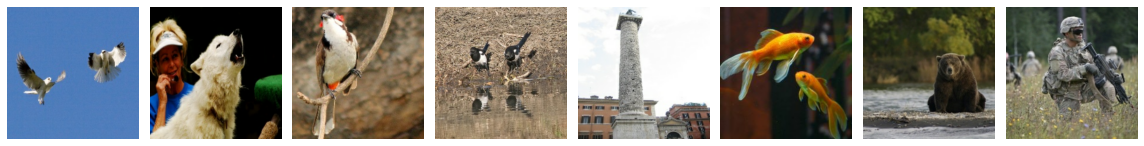

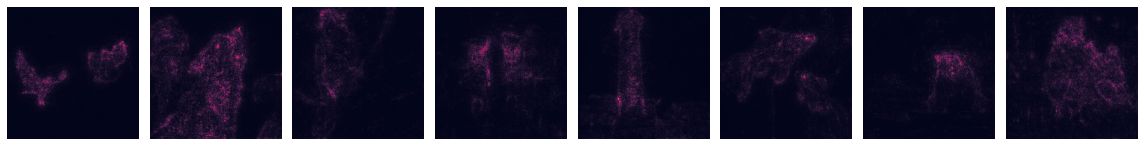

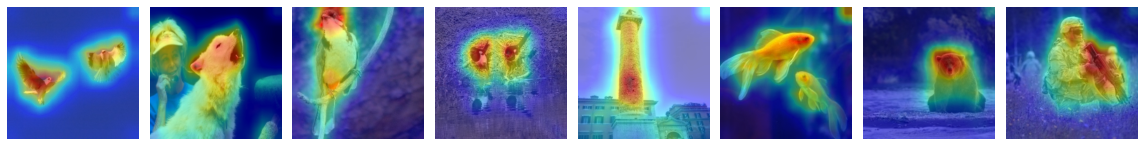

In [20]:
#@title

utils.plot(to_image(images[:8]))
utils.plot(s[:8])
utils.plot_heatmaps(to_image(images[:8]), maps)

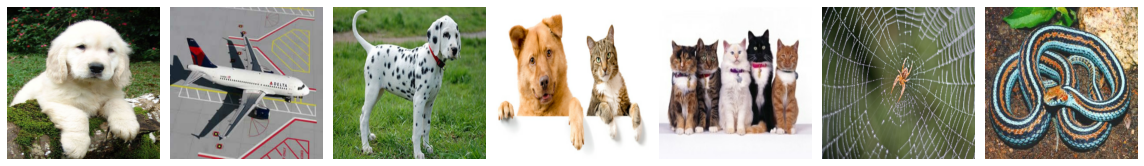

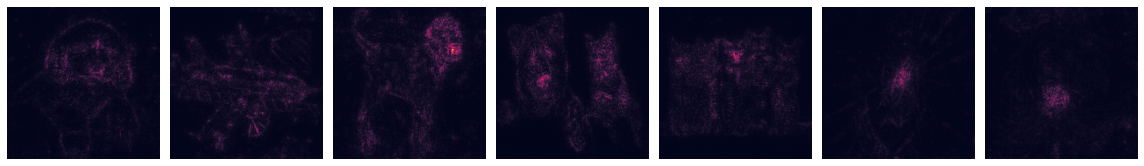

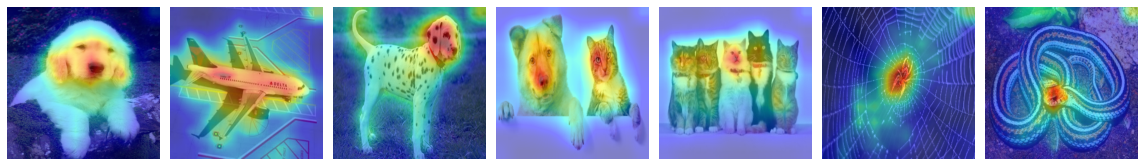

In [21]:
#@title

utils.plot(to_image(images[8:]))
utils.plot(s[8:])
utils.plot_heatmaps(to_image(images[8:]), maps[8:])

## Guided FullGrad Backpropagation

In [22]:
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers import VersionAwareLayers

@tf.custom_gradient
def guided_relu(x, max_value=None):
    def grad(dy):
        f = dy > 0
        r = x > 0
        if max_value is not None: r &= x <= max_value
        return dy * tf.cast(f & r, dy.dtype), None

    x = tf.nn.relu(x)

    if max_value is not None:
        zero = tf.constant(0, tf.float32)
        x = tf.clip_by_value(x, zero, max_value)

    return x, grad

@tf.custom_gradient
def guided_swish(x):
    def grad(dy):
        with tf.control_dependencies([dy]):
            sx = tf.math.sigmoid(x)

        f = dy > 0
        r = x > 0

        g = (sx * (1.0 + x * (1.0 - sx)))
        return dy * tf.cast(f & r, dy.dtype) * g

    return x * tf.math.sigmoid(x), grad

class GuidedReLU(tf.keras.layers.ReLU):
    def call(self, inputs):
        return guided_relu(inputs, self.max_value)

layers = VersionAwareLayers()
layers.ReLU = GuidedReLU

In [23]:
for l in nn.layers:
    if not hasattr(l, 'activation'):
        continue

    if l.activation is tf.keras.activations.relu:
        l.activation = guided_relu
    if l.activation is tf.keras.activations.swish:
        l.activation = guided_swish

In [24]:
nn_s = tf.keras.Model(nn.inputs, [nn.output, *intermediates], name='spacial_model')

In [25]:
@tf.function
def gradients(inputs, units):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        y, *ia = nn_s(inputs, training=False)
        loss = activation_gain(y, units)
    
    grads, *ig = tape.gradient(loss, [inputs, *ia])

    return loss, grads, ig

In [26]:
@tf.function
def fullgrads(inputs, units):
    loss, dydx, dydas = gradients(inputs, units)

    maps = tf.reduce_sum(psi(dydx * inputs), axis=-1)

    Gb = [ig * tf.reshape(b, (1, 1, 1, -1)) for ig, b in zip(dydas, biases)]
    for b in Gb:
        b = psi(b)
        maps += tf.reduce_sum(tf.image.resize(b, config.data.image_size), axis=-1)

    return loss, dydx, maps

In [27]:
r = zip(*[fullgrads(x[ix:ix+1], preds[ix:ix+1]) for ix in range(len(images))])
_, g, maps = (tf.concat(e, axis=0) for e in r)

In [28]:
maps = normalize(maps)

s = normalize(tf.reduce_sum(tf.abs(g), axis=-1))

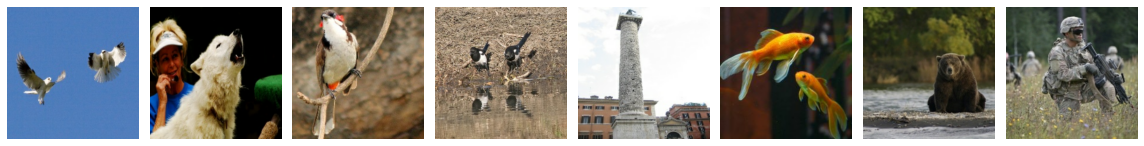

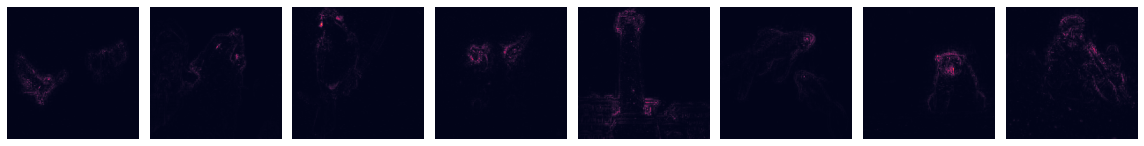

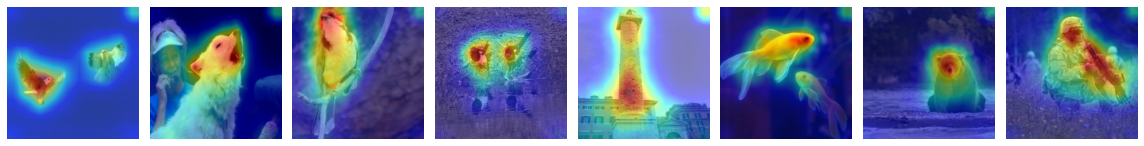

In [29]:
#@title

utils.plot(to_image(images[:8]))
utils.plot(s[:8])
utils.plot_heatmaps(to_image(images[:8]), maps)

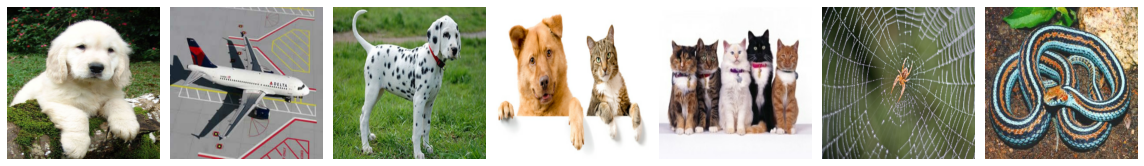

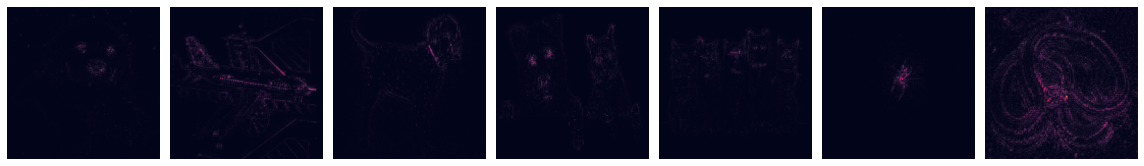

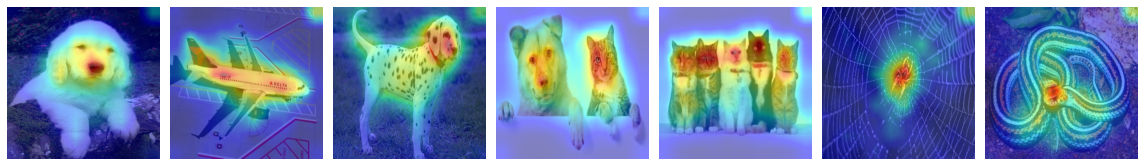

In [30]:
#@title

utils.plot(to_image(images[8:]))
utils.plot(s[8:])
utils.plot_heatmaps(to_image(images[8:]), maps[8:])